## **Virus Classification**

+ **Datasets**: chest-xray-pneumonia + covidx-cxr2

+ **Classes**: Normal, Pneumonia, Covid_19

+ **Models**: GoogLeNet, DenseNet121

In [6]:
import os
import cv2
import platform
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

os.environ['PYTHONHASHSEED'] = '73'

seed = 73
random.seed(seed)
np.random.seed(seed)

print(platform.platform())
%matplotlib inline

Windows-10-10.0.22631-SP0


In [7]:
!nvidia-smi

Fri Nov 10 14:31:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 462.96       Driver Version: 462.96       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000    WDDM  | 00000000:41:00.0  On |                  N/A |
| 30%   40C    P8    14W / 125W |   1045MiB /  8192MiB |     10%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
!dir "C:\image\Mydrive\kaggle\input"

 Volume in drive C has no label.
 Volume Serial Number is 5C9E-EF55

 Directory of C:\image\Mydrive\kaggle\input

10/11/2023  02:28 PM    <DIR>          .
24/06/2022  01:25 PM    <DIR>          ..
24/06/2022  09:20 AM    <DIR>          chest-xray-pneumonia
24/06/2022  09:38 AM    <DIR>          covidx-crx2
10/11/2023  02:28 PM    <DIR>          Tuberculosis (TB) Chest X-ray Database kaggle
               0 File(s)              0 bytes
               5 Dir(s)  71,923,949,568 bytes free


In [9]:
DataDir = 'C:\image\Mydrive\kaggle\input\covidx-crx2'

print('> Covid 19 dir:', os.listdir(DataDir))

PneumoniaDir = 'C:\image\Mydrive\kaggle\input\chest-xray-pneumonia\chest_xray'

print('> Pneumonia dir:', os.listdir(PneumoniaDir))

TuberculosisDir = 'C:\image\Mydrive\kaggle\input\Tuberculosis (TB) Chest X-ray Database kaggle\TB_Chest_Radiography_Database'

print('> Tuberculosis dir:', os.listdir(TuberculosisDir))

> Covid 19 dir: ['test', 'test.txt', 'train', 'train.txt']
> Pneumonia dir: ['chest_xray', 'test', 'train', 'val', '__MACOSX']
> Tuberculosis dir: ['Normal.metadata.xlsx', 'README.md.txt', 'TEST', 'TRAIN', 'Tuberculosis.metadata.xlsx', 'VAL']


## **Data Preparation**

In [10]:
from tqdm import tqdm

train_image_dir = TuberculosisDir + '/train'
test_image_dir = TuberculosisDir + '/test'
val_image_dir = TuberculosisDir + '/val'

img_map = []

def prepareData(Dir, strat):
    cats = ["NORMAL","TUBERCULOSIS"]
    for category in cats:
        path = os.path.join(Dir,category)
        class_num = cats.index(category)
        
        for img in tqdm(os.listdir(path)):
            img_path = os.path.join(path,img)
            img_map.append({'path': img_path, 'label': category})

prepareData(train_image_dir,'train')
prepareData(test_image_dir,'test')
prepareData(val_image_dir, 'val')

img_map = pd.DataFrame(img_map).sample(frac = 1, random_state=seed)

100%|██████████| 100/100 [00:00<?, ?it/s]


### **Getting image path and labels from *.txt files**


In [11]:
#ricord, rsna, cohen, actmed, sirm, 
def getClass(label):
    if label == 'negative':
        return 'NORMAL'
    if label == 'positive':
        return 'COVID'

def get_image_map(txt_path, strat):
    train_txt = open(txt_path, 'r')
    Lines = train_txt.readlines()
    paths = []
    
    img_formats = ['jpg', 'jpeg', 'png']
    
    for n, line in enumerate(Lines):
        querywords = line.split()

        if len(querywords) == 4:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[1]
            label = querywords[2]

        if len(querywords) == 5:
            image_id = querywords[0]
            image_path = DataDir + '/' + strat + '/'+ querywords[2]
            label = querywords[3]
            
        for img_type in img_formats:
            if img_type in line:
                obj_ = {'path': image_path, 'label': getClass(label)}
                if (('positive' in line) | ('negative' in line)):
                    paths.append(obj_)

    paths_df = pd.DataFrame(paths)
    return paths_df


In [12]:
train_map = get_image_map(DataDir + '/train.txt', 
                          strat='train').sample(frac = 1, random_state=73)

test_map = get_image_map(DataDir + '/test.txt',
                         strat='test').sample(frac = 1, random_state=73)


In [13]:
img_path_map = pd.concat([img_map, train_map, test_map], axis=0).sample(frac = 1, random_state=73)

### **Visualization**

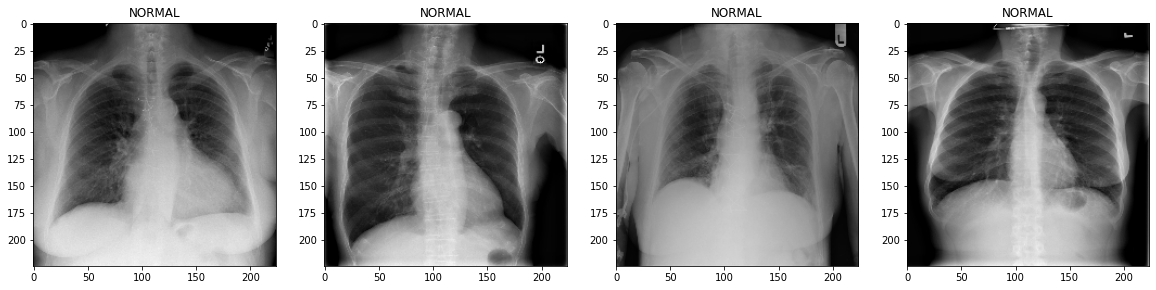

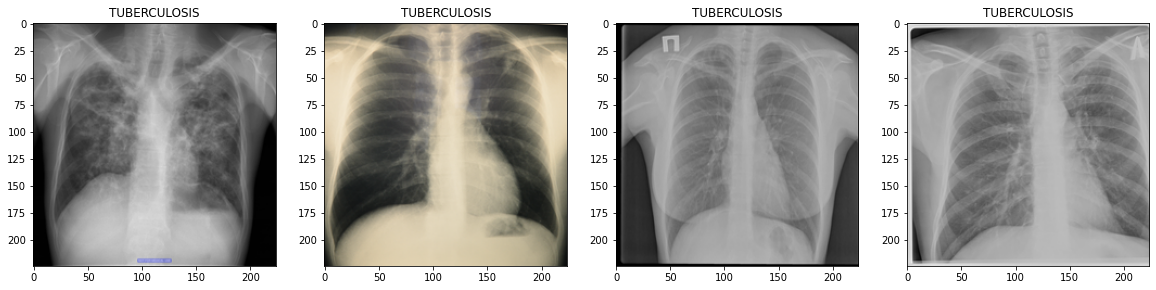

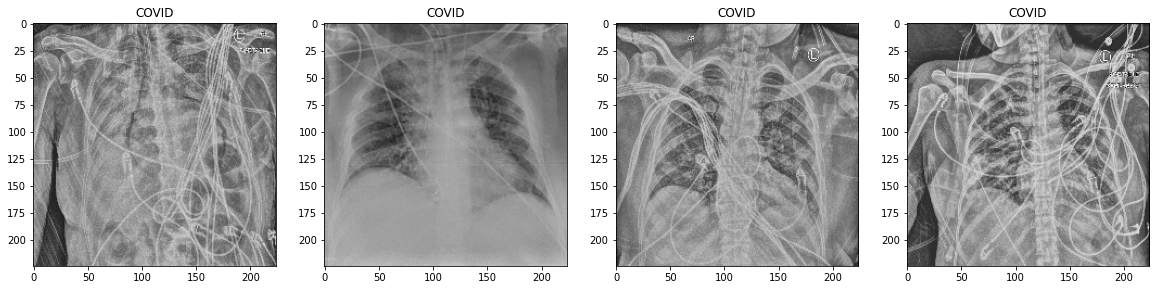

In [14]:
import matplotlib.pyplot as plt

def print_images(samples): 
    images = samples["path"].to_numpy()
    labels = samples['label'].to_numpy()
    
    fig=plt.figure(figsize=(20, 8))
    columns = 4
    rows = 1
    
    for i, image_path in enumerate(images):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        fig.add_subplot(rows,columns,i + 1)
        title = '{}'.format(labels[i])
        
        Sample_image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
        
        plt.imshow(Sample_image, cmap='gray')
        plt.title(title)
        
    plt.show()
        

print_images(img_path_map[img_path_map['label']=="NORMAL"].iloc[0:4])
print_images(img_path_map[img_path_map['label']=="TUBERCULOSIS"].iloc[0:4])
print_images(img_path_map[img_path_map['label']=="COVID"].iloc[0:4])

%matplotlib inline

In [15]:
def getLabelCount(frame):
    label_count = pd.Series(frame['label'].values.ravel()).value_counts()
    n_classes = (label_count)
    return label_count

label_count = getLabelCount(img_path_map)
print(label_count)

NORMAL          17690
COVID           16194
TUBERCULOSIS      700
dtype: int64


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

features = img_path_map['path'].to_numpy()
labels = img_path_map['label'].to_numpy()

stratified_sample = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=73)

In [17]:
for train_index, test_index in stratified_sample.split(features, labels):
    X_train, test_X = features[train_index], features[test_index]
    y_train, test_y = labels[train_index], labels[test_index]
    
half_size = int(len(test_X) / 2)
X_test, y_test = test_X[0:half_size], test_y[0:half_size]
X_val, y_val = test_X[half_size:], test_y[half_size:]

In [18]:
train_map = pd.DataFrame()
train_map['path'], train_map['label'] = X_train, y_train

In [19]:
test_map = pd.DataFrame()
test_map['path'], test_map['label'] = X_test, y_test

In [20]:
val_map = pd.DataFrame()
val_map['path'], val_map['label'] = X_val, y_val

In [21]:
# data summary
print('> {} train size'.format(X_train.shape[0]))
print('> {} test size'.format(X_test.shape[0]))
print('> {} val size'.format(X_val.shape[0]))

> 27667 train size
> 3458 test size
> 3459 val size


In [22]:
import cv2
import time
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
ia.seed(73)

ColorCh = 3
IMG_SIZE = 224
input_shape=(IMG_SIZE, IMG_SIZE, ColorCh)

classes = ("COVID", "NORMAL","PNEUMONIA")
CATEGORIES = sorted(classes)

print('> Classes:',CATEGORIES)

> Classes: ['COVID', 'NORMAL', 'PNEUMONIA']


In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array, load_img
datagen = ImageDataGenerator(rescale = 1./255, 
                             horizontal_flip=True,
                             brightness_range=[1.0,1.3],
                             rotation_range=15,
                             #zoom_range=0.2
                            )

In [24]:
batch_size = 64

def get_generator(frame_):
    generator = datagen.flow_from_dataframe(
                          dataframe=frame_,
                          x_col="path",
                          y_col="label",
                          batch_size=batch_size,
                          seed=seed,
                          shuffle=False,
                          class_mode="sparse",
                          color_mode="rgb",
                          save_format="jpeg",
                          target_size=(IMG_SIZE,IMG_SIZE)             
             )
    
    return generator

In [25]:
train_df = train_map.sample(frac=1, random_state=seed)
train_generator = get_generator(train_df)

print('> label count for train set')
getLabelCount(train_df)

Found 27667 validated image filenames belonging to 3 classes.
> label count for train set


NORMAL          14152
COVID           12955
TUBERCULOSIS      560
dtype: int64

In [26]:
test_df = test_map.sample(frac=1, random_state=seed)
test_generator = get_generator(test_df)

print('> label count for test set')
getLabelCount(test_df)

Found 3458 validated image filenames belonging to 3 classes.
> label count for test set


NORMAL          1770
COVID           1615
TUBERCULOSIS      73
dtype: int64

In [27]:
val_df = val_map.sample(frac=1, random_state=seed)
val_generator = get_generator(val_df)

print('> label count for val set')
getLabelCount(val_df)

Found 3459 validated image filenames belonging to 3 classes.
> label count for val set


NORMAL          1768
COVID           1624
TUBERCULOSIS      67
dtype: int64

In [28]:
print('> input shape:', input_shape)

> input shape: (224, 224, 3)


## **Building Models**

In [29]:
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Flatten, Add, add
from keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras import regularizers

kernel_regularizer = regularizers.l2(0.0001)

final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy'
n_classes = len(CATEGORIES)
print('> {} classes'.format(n_classes))

> 3 classes


In [30]:
def FCLayers(baseModel):
    baseModel.trainable = True
    headModel = baseModel.output
    headModel = Dropout(0.5, seed=73)(headModel)
    headModel = Dense(n_classes, activation=final_activation)(headModel)
    model = Model(inputs = baseModel.input, outputs = headModel)
    5
    return model

## **GoogLenet**

**Blog Reference**: https://medium.com/mlearning-ai/implementation-of-googlenet-on-keras-d9873aeed83c

### **Inception Block**

![](https://miro.medium.com/max/2400/1*zIcot5nm9q_TC8zqcGQ7Dg.png)

In [31]:
from keras.layers import concatenate

def Inception_block(input_layer, f1, f2, f3, f4):    
    
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    
    path2 = Conv2D(filters = f2[0], kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(input_layer)
    
    path2 = Conv2D(filters = f2[1], kernel_size = (3,3), 
                   padding = 'same', activation = 'relu')(path2)

    path3 = Conv2D(filters = f3[0], kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(input_layer)
    
    path3 = Conv2D(filters = f3[1], kernel_size = (5,5), 
                   padding = 'same', activation = 'relu')(path3)

    path4 = MaxPooling2D((3,3), strides= (1,1), 
                         padding = 'same')(input_layer)
    
    path4 = Conv2D(filters = f4, kernel_size = (1,1), 
                   padding = 'same', activation = 'relu')(path4)
    
    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

![](https://miro.medium.com/max/664/1*4nb4lVJnaKJZAu6Lthuz2Q.png)

In [32]:
# auxiliary_classifiers
def Extra_network_2(X):
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), 
                padding = 'same', activation = 'relu')(X2)
    
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.5)(X2)
    X2 = Dense(n_classes, activation = final_activation, name="output2")(X2)
    return X2


def Extra_network_1(X):
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), 
                padding = 'same', activation = 'relu')(X1)
    
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.5)(X1)
    X1 = Dense(n_classes, activation = final_activation, name="output1")(X1)
    return X1

In [33]:
def layer_4(X):
    X = Inception_block(X, 192, (96, 208) , (16, 48), 64)
    
    X1 = Extra_network_1(X)
    
    X = Inception_block(X, 160, (112, 224), (24, 64), 64)
    X = Inception_block(X, 128, (128, 256), (24, 64), 64)
    X = Inception_block(X, 112, (144, 288), (32, 64), 64)
    
    X2 = Extra_network_2(X)
    
    X = Inception_block(X, 256, (160, 320), (32, 128), 128)
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    return X, X1, X2

def layer_3(X):
    X = Inception_block(X, 64, (96, 128), (16, 32), 32)
    X = Inception_block(X, 128, (128, 192), (32, 96), 64)
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)
    
    return X

def layer_2(X):
    X = Conv2D(filters = 64, 
               kernel_size = 1, 
               strides = 1, 
               padding = 'same', 
               activation = 'relu')(X)
    
    X = Conv2D(filters = 192, 
               kernel_size = 3, 
               padding = 'same', 
               activation = 'relu')(X)
    
    X = MaxPooling2D(pool_size= 3, strides = 2)(X)
    
    return X

In [34]:
def load_GoogLeNet():
    input_layer = Input(shape = input_shape)
    
    X = Conv2D(64, kernel_size = 7, strides = 2, 
               padding = 'valid', activation = 'relu')(input_layer)
    
    X = MaxPooling2D(pool_size = 3, strides = 2)(X)
    
    X = layer_2(X)
    X = layer_3(X)
    X, X1, X2 = layer_4(X)

    X = Inception_block(X, 256, (160, 320), (32, 128), 128)
    X = Inception_block(X, 384, (192, 384), (48, 128), 128)

    X = GlobalAveragePooling2D()(X)
    X = Dropout(0.6)(X)
    
    X = Dense(n_classes, activation = final_activation, name="output3")(X)
  
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model

load_GoogLeNet().summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 54, 54, 64)   0           ['conv2d[0][0]']                 
                                                                                          

## **DenseNet121**

In [35]:
from keras.applications import DenseNet121

def load_DenseNet121():
    input_tensor = Input(shape=input_shape)
    baseModel = DenseNet121(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    model = FCLayers(baseModel)
    return model

load_DenseNet121().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [36]:
def getMetrics(name, type_):
    if name == 'GoogLeNet':
        if type_ == 'accuracy':
            return 'output3_accuracy'
        if type_ == 'loss':
            return 'output3_loss'
        if type_ == 'val_accuracy':
            return 'val_output3_accuracy'
        if type_ == 'val_loss':
            return 'val_output3_loss'
        
    else:
        if type_ == 'accuracy':
            return 'accuracy'
        if type_ == 'loss':
            return 'loss'
        if type_ == 'val_accuracy':
            return 'val_accuracy'
        if type_ == 'val_loss':
            return 'val_loss'

## **Call Backs**

In [37]:
from keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
          
EPOCHS = 120
patience = 3

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8
        
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
        
def getCallbacks(name):
    class myCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if ((logs.get(getMetrics(name,'accuracy'))>=0.999)):
                print("\nLimits Reached cancelling training!")
                self.model.stop_training = True

            
    end_callback = myCallback()

    lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

    lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

    early_stopping = EarlyStopping(patience = patience, monitor=getMetrics(name, 'val_loss'),
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)


    checkpoint_filepath = name + '_Weights.h5'

    model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor=getMetrics(name, 'val_loss'),
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

    import datetime
    log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  
    tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

    return [end_callback, 
             lr_callback, 
             model_checkpoints,
             early_stopping,
             #tensorboard_callback,
             lr_plat
            ]

GoogLeNet_callbacks = getCallbacks('GoogLeNet')
callbacks = getCallbacks('DenseNet121')

## **Compile** and **Fit Model**

In [38]:
def CompileModel(name, model):
    if name == 'GoogLeNet':
        model.compile(optimizer='adam', loss=entropy, metrics={"output1":"accuracy", "output2":"accuracy", "output3":"accuracy"})
    else:
        model.compile(optimizer='adam', loss=entropy, metrics=["accuracy"])
    return model

def FitModel(model, name):
    callbacks_ = callbacks
    if name == 'GoogLeNet':
        callbacks_ = GoogLeNet_callbacks
    history = model.fit(train_generator, 
                        epochs=EPOCHS,
                        callbacks=callbacks_,
                        validation_data = val_generator,
                        steps_per_epoch=(len(train_generator.labels) / 80),
                        validation_steps=(len(val_generator.labels) / 80),
                       )
    
    model.load_weights(name + '_Weights.h5')

    final_accuracy_avg = np.mean(history.history[getMetrics(name, "val_accuracy")][-5:])

    final_loss = history.history[getMetrics(name, "val_loss")][-1]
  
    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss: 'loss'}

    print('\n')
    print('---'*15)
    print(name,' Model')
    print('Total Epochs :', len(history.history[getMetrics(name, 'loss')]))    
    print('Restoring best Weights')
    
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('---'*15)
    print('Best Epoch :', index)
    print('---'*15)
    
    train_accuracy = history.history[getMetrics(name, 'accuracy')][index]
    train_loss = history.history[getMetrics(name, 'loss')][index]
    
    val_accuracy = history.history[getMetrics(name, 'val_accuracy')][index]
    val_loss = history.history[getMetrics(name, 'val_loss')][index]

    print('Accuracy on train:', train_accuracy,
          '\tLoss on train:', train_loss)
    
    print('Accuracy on val:', val_accuracy ,
          '\tLoss on val:', val_loss)
    print('---'*15)

    return model, history

In [39]:
def BuildModel(name):
    if name == 'GoogLeNet':
        prepared_model = load_GoogLeNet() 
    if name == 'DenseNet121':
        prepared_model = load_DenseNet121()
        
    compiled_model = CompileModel(name, prepared_model)
    return compiled_model

## **Training GoogLeNet**

In [40]:
g_compiled_model = BuildModel('GoogLeNet')
g_model, g_history = FitModel(g_compiled_model, 'GoogLeNet')

Epoch 1/120
346/345 [==============================] - ETA: 0s - loss: 2.4787 - output3_loss: 0.8299 - output1_loss: 0.8225 - output2_loss: 0.8264 - output3_accuracy: 0.5140 - output1_accuracy: 0.5389 - output2_accuracy: 0.5199
Epoch 1: val_output3_loss improved from inf to 0.76002, saving model to GoogLeNet_Weights.h5
345/345 [==============================] - 1691s 5s/step - loss: 2.4787 - output3_loss: 0.8299 - output1_loss: 0.8225 - output2_loss: 0.8264 - output3_accuracy: 0.5140 - output1_accuracy: 0.5389 - output2_accuracy: 0.5199 - val_loss: 2.2428 - val_output3_loss: 0.7600 - val_output1_loss: 0.7312 - val_output2_loss: 0.7516 - val_output3_accuracy: 0.5167 - val_output1_accuracy: 0.6932 - val_output2_accuracy: 0.6062 - lr: 1.0000e-05
Epoch 2/120
346/345 [==============================] - ETA: 0s - loss: 1.7203 - output3_loss: 0.5694 - output1_loss: 0.5824 - output2_loss: 0.5685 - output3_accuracy: 0.7372 - output1_accuracy: 0.7333 - output2_accuracy: 0.7399
Epoch 2: val_output

## **Training DenseNet121**

In [41]:
d_compiled_model = BuildModel('DenseNet121')
d_model, d_history = FitModel(d_compiled_model, 'DenseNet121')

Epoch 1/120
346/345 [==============================] - ETA: -2s - loss: 0.5781 - accuracy: 0.7833
Epoch 1: val_loss improved from inf to 0.30536, saving model to DenseNet121_Weights.h5
345/345 [==============================] - 6537s 19s/step - loss: 0.5781 - accuracy: 0.7833 - val_loss: 0.3054 - val_accuracy: 0.9048 - lr: 1.0000e-05
Epoch 2/120
346/345 [==============================] - ETA: -2s - loss: 0.1729 - accuracy: 0.9436
Epoch 2: val_loss improved from 0.30536 to 0.09817, saving model to DenseNet121_Weights.h5
345/345 [==============================] - 6485s 19s/step - loss: 0.1729 - accuracy: 0.9436 - val_loss: 0.0982 - val_accuracy: 0.9656 - lr: 1.8000e-05
Epoch 3/120
346/345 [==============================] - ETA: -2s - loss: 0.0984 - accuracy: 0.9686
Epoch 3: val_loss improved from 0.09817 to 0.07771, saving model to DenseNet121_Weights.h5
345/345 [==============================] - 6506s 19s/step - loss: 0.0984 - accuracy: 0.9686 - val_loss: 0.0777 - val_accuracy: 0.9766 -

## **Model Evaluation on the TestSet**

In [42]:
%matplotlib inline
def print_graph(item, index, history):
    plt.figure()
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [43]:
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, accuracy_score, classification_report, confusion_matrix

def test_set_results(pred_value, n=1):    
    y_test = test_generator.labels
    X_test, _ = test_generator.next()
    
    corr_pred = metrics.confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Dense Output {}'.format(n))
    plt.show()
    
    n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_generator.labels, pred_value, target_names=CATEGORIES))

In [44]:
def printResults(name, model):
    predictions = model.predict(test_generator, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [45]:
def model_summary(model, history, name):
    index = (len(history.history[getMetrics(name, 'loss')]) - (patience + 1))
    print('Best Epochs: ', index)
    
    if name == 'GoogLeNet':
        results = model.evaluate(test_generator, verbose=1)
        loss, output3_loss, output1_loss, output2_loss, output3_accuracy, output1_accuracy, output2_accuracy = results
        
        for i in range(3):
            n = i + 1
            out_layer = 'Output Layer {}'.format(n)
            
            if n == 1:
                test_accuracy = output1_accuracy
                test_loss = output1_loss

            if n == 2:
                test_accuracy = output2_accuracy
                test_loss = output2_loss
                
            if n == 3:
                test_accuracy = output3_accuracy
                test_loss = output3_loss
                
                
            output_name = 'output{}_'.format(n)
            train_accuracy, train_loss = history.history[output_name + 'accuracy'][index], history.history[output_name + 'loss'][index]
            
  
            print_graph(output_name + 'loss', index, history)
            print_graph(output_name + 'accuracy', index, history)
        
            print('---'*15)  
            print('GoogLeNet Dense output {}:'.format(n))
            
            print('> Accuracy on train :'.format(out_layer), train_accuracy, 
                  '\tLoss on train:',train_loss)
        
            print('> Accuracy on test :'.format(out_layer), test_accuracy,
                  '\tLoss on test:',test_loss)
            
            print('---'*15)
            print('> predicting test')
            print('---'*15)
            
            predictions = model.predict(test_generator, verbose=1)
            preds = np.argmax(predictions[i], axis=1)
            test_set_results(preds, n)
                
    else:
        test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
        
        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]

        print_graph('loss', index, history)
        print_graph('accuracy', index, history)
        
        print('---'*15) 
        print(name)
        print('> Accuracy on train:',train_accuracy, 
              '\tLoss on train:',train_loss)
        
        print('> Accuracy on test:',test_accuracy,
              '\tLoss on test:',test_loss)
        
        print('---'*15)
        print('> predicting test')
        print('---'*15)
        
        printResults(name, model)

## **GoogLeNet Results**

Best Epochs:  20
55/55 [==============================] - 131s 2s/step - loss: 0.5236 - output3_loss: 0.1552 - output1_loss: 0.2117 - output2_loss: 0.1566 - output3_accuracy: 0.9430 - output1_accuracy: 0.9202 - output2_accuracy: 0.9413


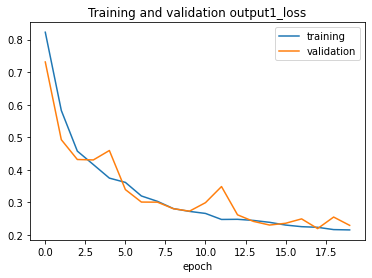

<Figure size 432x288 with 0 Axes>

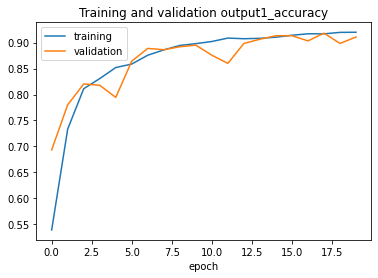

---------------------------------------------
GoogLeNet Dense output 1:
> Accuracy on train : 0.9225756525993347 	Loss on train: 0.2120741903781891
> Accuracy on test : 0.9201850891113281 	Loss on test: 0.21174579858779907
---------------------------------------------
> predicting test
---------------------------------------------
55/55 [==============================] - 94s 2s/step


<Figure size 432x288 with 0 Axes>

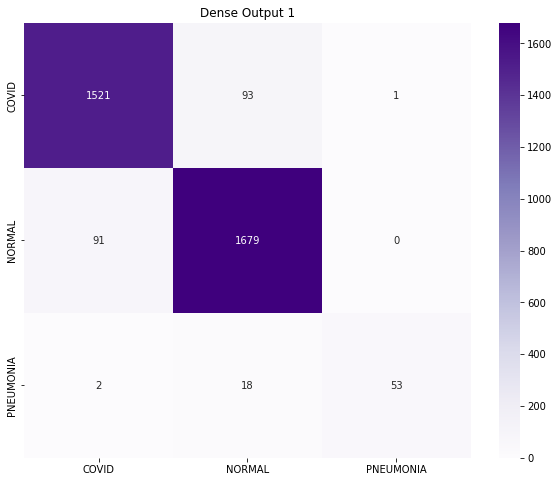

C:\Users\User\AppData\Local\Temp\ipykernel_17148\2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


.............................................
> Correct Predictions: 3253
> Wrong Predictions: 205
.............................................
              precision    recall  f1-score   support

       COVID       0.94      0.94      0.94      1615
      NORMAL       0.94      0.95      0.94      1770
   PNEUMONIA       0.98      0.73      0.83        73

    accuracy                           0.94      3458
   macro avg       0.95      0.87      0.91      3458
weighted avg       0.94      0.94      0.94      3458



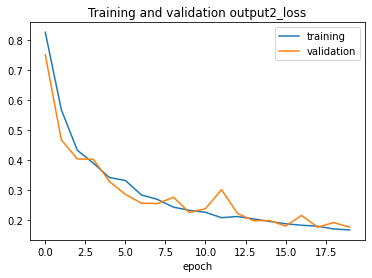

<Figure size 432x288 with 0 Axes>

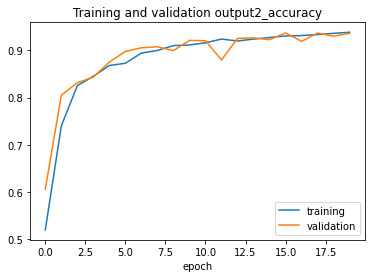

---------------------------------------------
GoogLeNet Dense output 2:
> Accuracy on train : 0.9405855536460876 	Loss on train: 0.1652601659297943
> Accuracy on test : 0.9412955641746521 	Loss on test: 0.1566367894411087
---------------------------------------------
> predicting test
---------------------------------------------
55/55 [==============================] - 94s 2s/step


<Figure size 432x288 with 0 Axes>

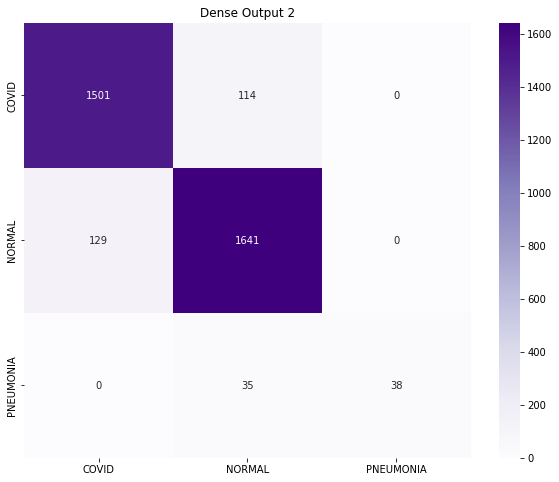

.............................................
> Correct Predictions: 3180
> Wrong Predictions: 278
.............................................
              precision    recall  f1-score   support

       COVID       0.92      0.93      0.93      1615
      NORMAL       0.92      0.93      0.92      1770
   PNEUMONIA       1.00      0.52      0.68        73

    accuracy                           0.92      3458
   macro avg       0.95      0.79      0.84      3458
weighted avg       0.92      0.92      0.92      3458



C:\Users\User\AppData\Local\Temp\ipykernel_17148\2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


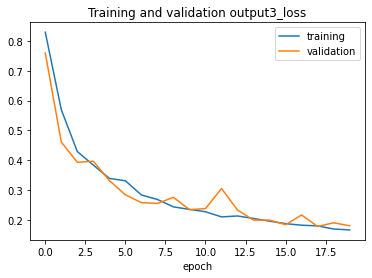

<Figure size 432x288 with 0 Axes>

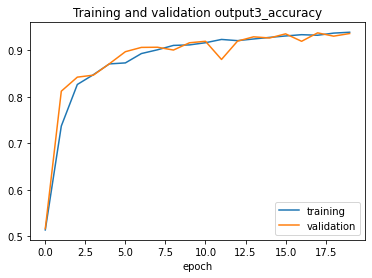

---------------------------------------------
GoogLeNet Dense output 3:
> Accuracy on train : 0.9407665729522705 	Loss on train: 0.1622190922498703
> Accuracy on test : 0.9430306553840637 	Loss on test: 0.1552414745092392
---------------------------------------------
> predicting test
---------------------------------------------
55/55 [==============================] - 94s 2s/step


<Figure size 432x288 with 0 Axes>

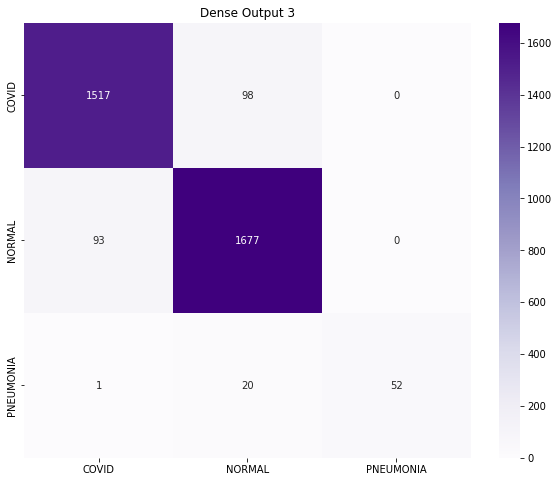

.............................................
> Correct Predictions: 3246
> Wrong Predictions: 212
.............................................
              precision    recall  f1-score   support

       COVID       0.94      0.94      0.94      1615
      NORMAL       0.93      0.95      0.94      1770
   PNEUMONIA       1.00      0.71      0.83        73

    accuracy                           0.94      3458
   macro avg       0.96      0.87      0.90      3458
weighted avg       0.94      0.94      0.94      3458



C:\Users\User\AppData\Local\Temp\ipykernel_17148\2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


In [46]:
model_summary(g_model, g_history, 'GoogLeNet')

## **DenseNet121 Results**

Best Epochs:  2
55/55 [==============================] - 219s 4s/step - loss: 0.0809 - accuracy: 0.9719


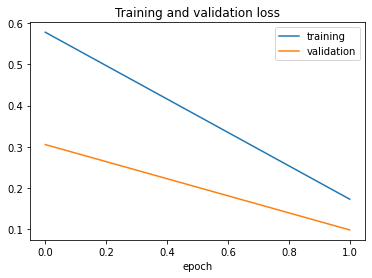

<Figure size 432x288 with 0 Axes>

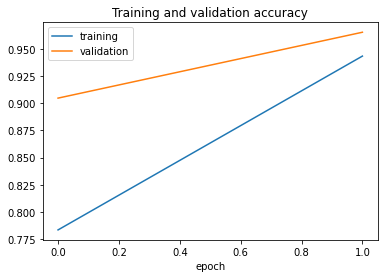

---------------------------------------------
DenseNet121
> Accuracy on train: 0.9685506224632263 	Loss on train: 0.09843569248914719
> Accuracy on test: 0.9719491004943848 	Loss on test: 0.0809023529291153
---------------------------------------------
> predicting test
---------------------------------------------
55/55 [==============================] - 223s 4s/step


<Figure size 432x288 with 0 Axes>

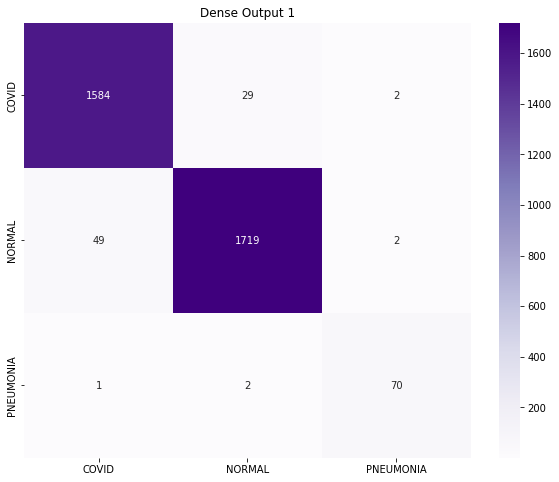

.............................................
> Correct Predictions: 3373
> Wrong Predictions: 85
.............................................
              precision    recall  f1-score   support

       COVID       0.97      0.98      0.98      1615
      NORMAL       0.98      0.97      0.98      1770
   PNEUMONIA       0.95      0.96      0.95        73

    accuracy                           0.98      3458
   macro avg       0.97      0.97      0.97      3458
weighted avg       0.98      0.98      0.98      3458



C:\Users\User\AppData\Local\Temp\ipykernel_17148\2559713061.py:17: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n_correct = np.int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])


In [47]:
model_summary(d_model, d_history, 'DenseNet121')

## **Saving Models**

In [48]:
from IPython.display import FileLink

In [49]:
g_model.save('GoogLeNet_model.h5')
FileLink(r'./GoogLeNet_model.h5')

c:\image\GoogLeNet_model.h5

In [50]:
d_model.save('DenseNet121_model.h5')
FileLink(r'./DenseNet121_model.h5')

c:\image\DenseNet121_model.h5

## **Deployed model**

+ **Models**: DenseNet121
+ **Size**: 85.9 MB
+ **Build With**: React Native
+ **Supported Versions**: ANDROID, IOS, WEB

In [51]:
from IPython.display import IFrame
IFrame(src='https://model-tester.web.app/covid_19', width='100%', height=1000)